In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_test
import seis_invert
import seis_prior
#import seis_nn
import cupy as cp
import seis_diagnostics
import seis_forward2

maxcor
F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


In [2]:
import numpy as np
np.log(32.4)

3.4781584227982836

In [3]:
data=kgs.load_all_train_data()
d = data[8011]
print(d.family)

Style_A


In [4]:
# importlib.reload(seis_prior)
# importlib.reload(seis_diagnostics)
# importlib.reload(seis_invert)
# kgs.profiling=False
# kgs.debugging_mode = 0
# seis_forward2.profiling=False
# seis_forward2.reset_profile()

# model = seis_invert.InversionModel()
# model.state = 1
# model.method = 'L-BFGS-B'
# model.maxiter = 5000
# model.prior = seis_prior.SquaredExponential()


# model.prior.basis_functions();
# w = cp.linalg.eigvalsh(model.prior.P)   
# plt.figure()
# plt.semilogy(cp.asnumpy(cp.abs(w)))

maxcor
capturing graph


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.58it/s]


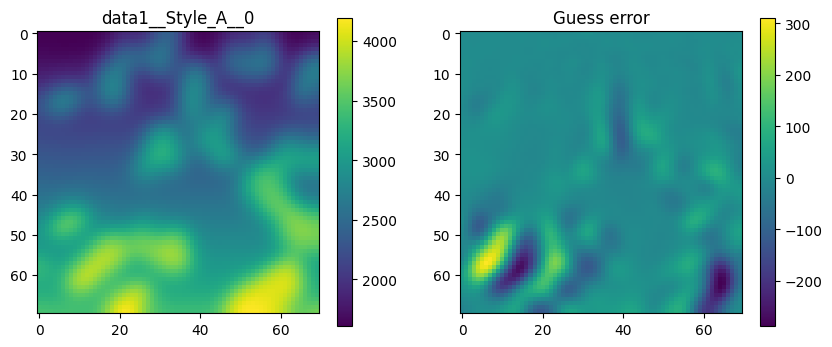

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

False False
(4901, 4901)
capturing graph


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

True False
(4901, 4901)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [14:42<00:00, 882.77s/it]


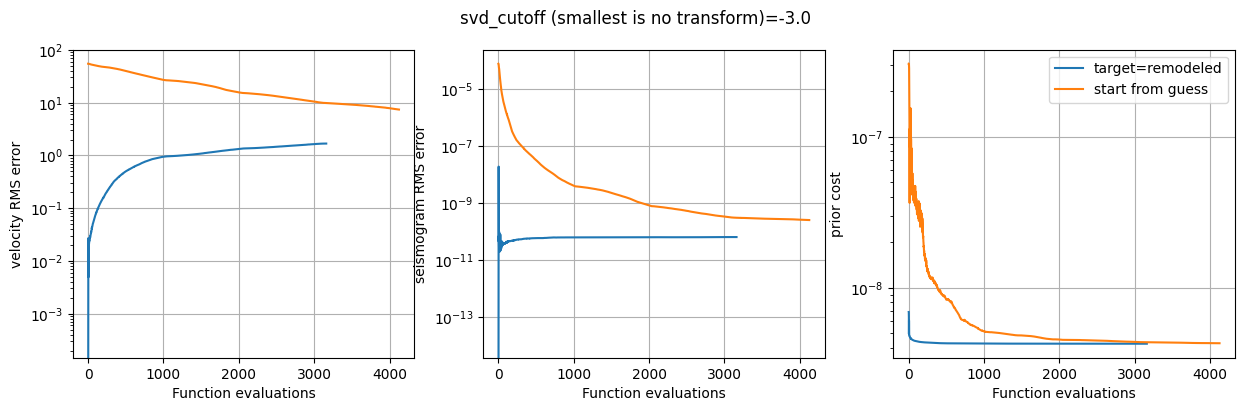

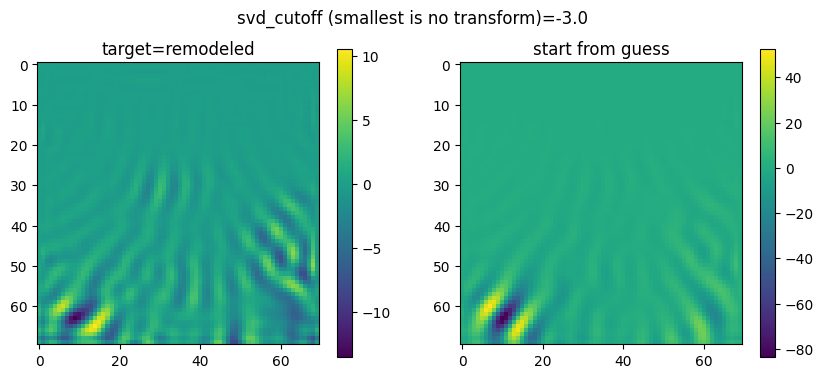

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

False True
(4901, 3712)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

True True
(4901, 3712)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [10:00<00:00, 600.51s/it]


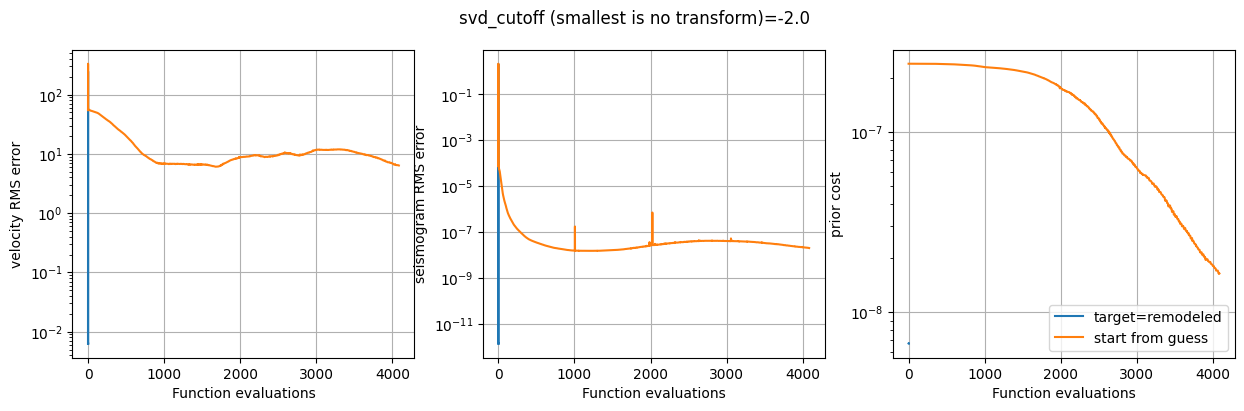

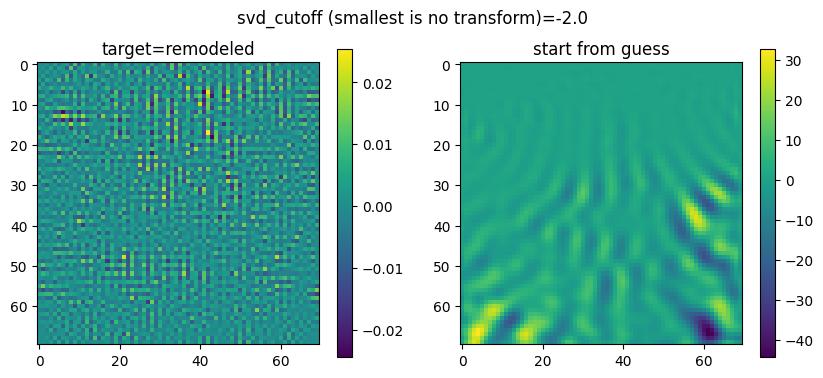

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

False True
(4901, 1259)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

True True
(4901, 1259)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [09:24<00:00, 564.77s/it]


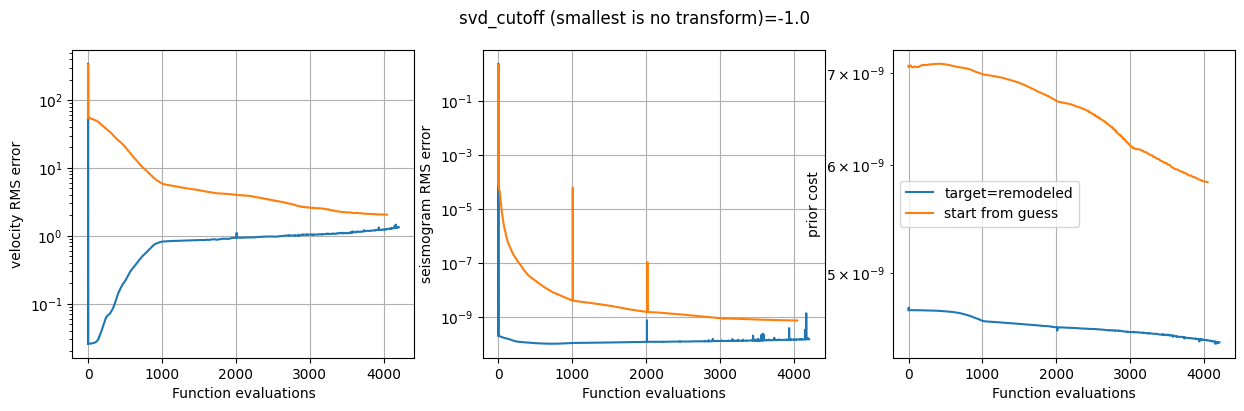

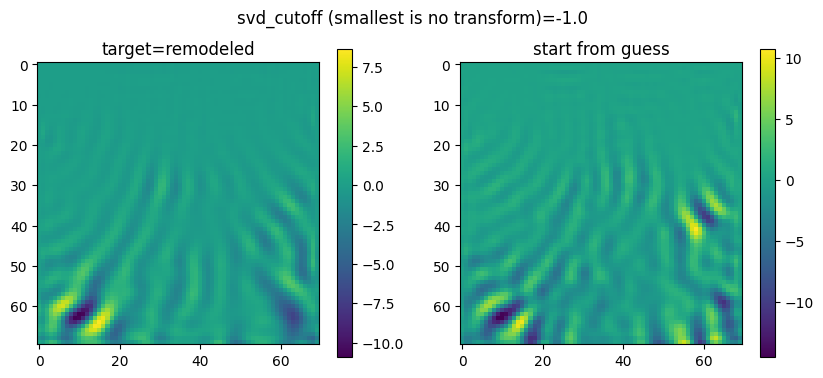

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

False True
(4901, 1073)


In [ ]:
importlib.reload(seis_prior)
importlib.reload(seis_diagnostics)
importlib.reload(seis_invert)
kgs.profiling=False
kgs.debugging_mode = 0
seis_forward2.profiling=False
seis_forward2.reset_profile()

model = seis_invert.InversionModel()
model.state = 1
model.method = 'L-BFGS-B'
model.maxiter = 4000
model.prior = seis_prior.SquaredExponential()
model.prior.transform = True
model.prior.svd_cutoff = 1.

do_which_list = [True,False,True]

def param_func(model,value):
    model.prior.λ = 10**value
    return model
param_values = np.linspace(-11,-11,1)
param_name = "log_prior_λ"
model.prior.λ = 10**-11

def param_func(model,value):
    model.prior.svd_cutoff = 10**value
    if value<-2.9:
        model.prior.transform =False
    return model
param_values = np.linspace(-3,2,6)
param_name = "svd_cutoff (smallest is no transform)"


for d in data[8000:8001]:
    results = seis_diagnostics.do_diagnostics_run(d, model, do_which_list, param_func, param_values, param_name)

In [ ]:
%debug

In [ ]:
seis_forward2.show_profile(1)